## Importing & Loading All We Need

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords

# Loading Our DataSet
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=['target', 'ids', 'date', 'flag', 'user', 'text'])


In [2]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### Checking For Duplicates

In [4]:
if data.duplicated().sum() > 0:   
    print("Duplicates do exist in the Data.")
else:
    print("No duplicates found in the Data.")

No duplicates found in the Data.


### Preprocess text data: 
1. remove links
2. mentions
3. special characters
4. convert to lowercase

In [5]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply text preprocessing to the dataset
data['cleaned_text'] = data['text'].apply(preprocess_text)

# remove stopwords
stop_words = set(stopwords.words('english'))
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Map target sentiment values: 0 -> Negative, 4 -> Positive
data['sentiment'] = data['target'].map({0: 'Negative', 4: 'Positive'})

## EDA

### Sentiment Over Time

/var/folders/hf/d6jmgkz95db_yxgvdcsq9fxw0000gn/T/ipykernel_2319/2603267193.py:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


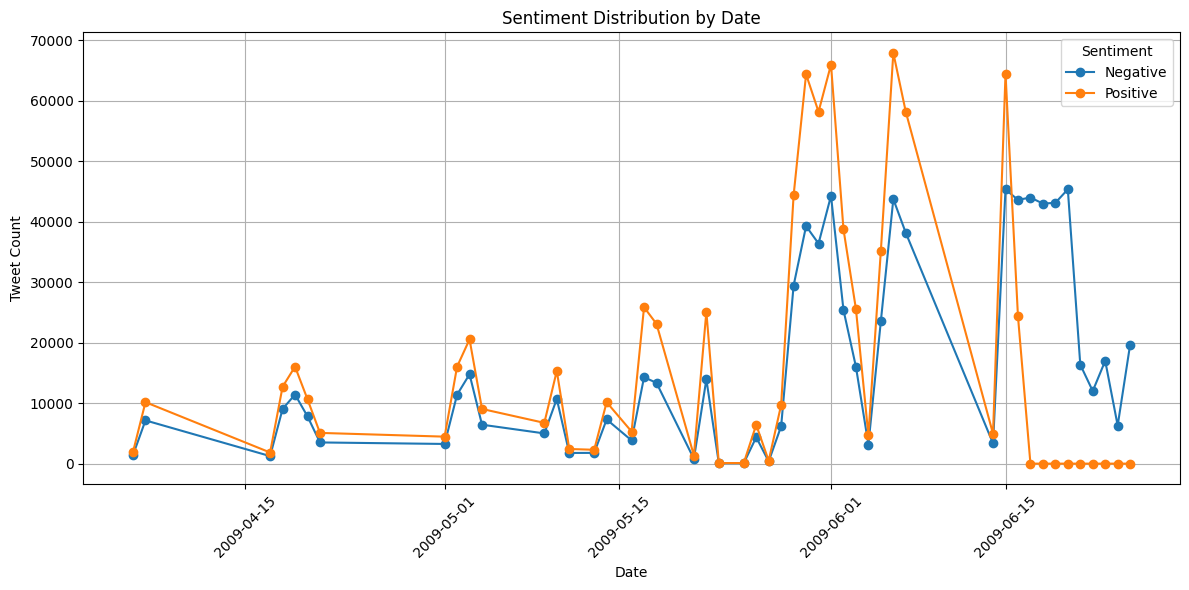

In [6]:
# Ensure 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Group by date and calculate sentiment distribution
sentiment_by_date = data.groupby([data['date'].dt.date, 'sentiment']).size().unstack().fillna(0)

# Plot sentiment distribution over time
sentiment_by_date.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Sentiment Distribution by Date')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Insight:

* The data shows a significant surge in both positive and negative sentiments between **late May** and early **June 2009**, indicating heightened public engagement likely driven by a major event or announcement.
  
* **Positive sentiment** peaked sharply around **early June**, **followed by a sudden drop**, while **negative sentiment remained relatively stable**, suggesting a potential shift in public perception or the emergence of controversy.

### Word Cloud for Each Sentiment

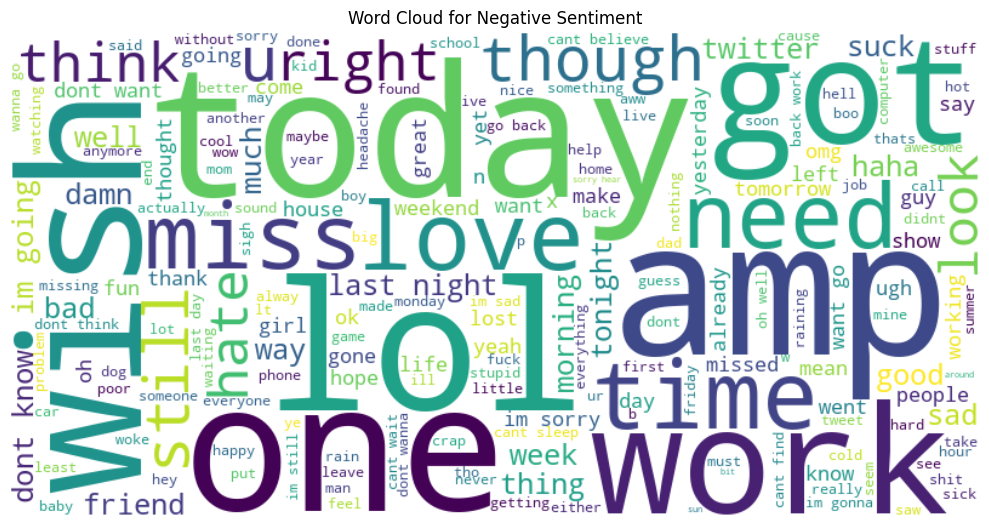

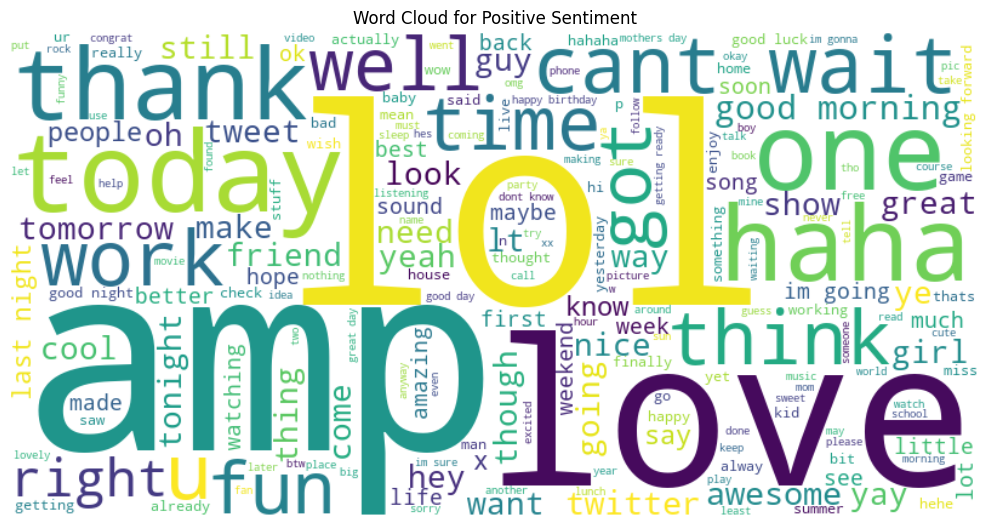

In [7]:
from wordcloud import WordCloud

# Generate word clouds for each sentiment
for sentiment in ['Negative', 'Positive']:
    sentiment_data = data[data['sentiment'] == sentiment]
    text = ' '.join(sentiment_data['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.tight_layout()
    plt.show()


### Insight:
* Words like **"love"**, **"today**", **"work"** and **"lol"** appear frequently in both **positive** and **negative sentiments**, highlighting that the same topics can evoke contrasting emotional responses depending on context.
  
* **Negative sentiment** is characterized by terms like **“hate”**, **“miss”**, **“wish”**, **“sad”** and **“suck”** while **positive sentiment** emphasizes words such as **“thank”**, **“fun”**, **“yay”**, **“awesome”** and **“amazing”** suggesting clear linguistic cues for sentiment polarity in social media text.

### Most Active Users By Tweet Count

In [8]:
# Grouping by user and sentiment, then count number of tweets
user_sentiment = data.groupby(['user', 'sentiment']).size().unstack().fillna(0)

# Find users with the most positive and negative tweets
most_positive_users = user_sentiment['Positive'].sort_values(ascending=False).head(10)
most_negative_users = user_sentiment['Negative'].sort_values(ascending=False).head(10)

print("Most Positive Users:\n", most_positive_users)
print("\nMost Negative Users:\n", most_negative_users)


Most Positive Users:
 user
what_bugs_u       246.0
DarkPiano         231.0
VioletsCRUK       218.0
tsarnick          212.0
keza34            211.0
shanajaca         204.0
TraceyHewins      193.0
ramdomthoughts    190.0
thisgoeshere      178.0
KevinEdwardsJr    171.0
Name: Positive, dtype: float64

Most Negative Users:
 user
lost_dog           549.0
tweetpet           310.0
webwoke            264.0
wowlew             210.0
mcraddictal        210.0
SallytheShizzle    183.0
_magic8ball        136.0
Dogbook            133.0
mrs_mcsupergirl    123.0
nuttychris         121.0
Name: Negative, dtype: float64


### Which Hashtags Drive the Most Engagement Per Sentiment?

In [9]:
# Define a function to extract hashtags
def extract_hashtags(text):
    return re.findall(r'#\w+', text.lower())

# Applying the function to get hashtags and aggregate by sentiment
data['hashtags'] = data['text'].apply(extract_hashtags)
hashtags_by_sentiment = data.groupby('sentiment')['hashtags'].sum()

top_hashtags = {sentiment: Counter(hashtags).most_common(10) for sentiment, hashtags in hashtags_by_sentiment.items()}

# Display top 10 hashtags for each sentiment
for sentiment, hashtags in top_hashtags.items():
    print(f"Top Hashtags for {sentiment} sentiment:")
    for hashtag, count in hashtags:
        print(f"{hashtag}: {count}")
    print("\n")


Top Hashtags for Negative sentiment:
#fb: 1059
#squarespace: 658
#iranelection: 439
#fail: 328
#iphone: 235
#1: 191
#inaperfectworld: 185
#bsb: 174
#2: 157
#iremember: 150


Top Hashtags for Positive sentiment:
#followfriday: 2496
#ff: 877
#fb: 727
#seb: 428
#musicmonday: 383
#1: 328
#squarespace: 283
#mcflyforgermany: 219
#myweakness: 218
#marsiscoming: 206




/var/folders/hf/d6jmgkz95db_yxgvdcsq9fxw0000gn/T/ipykernel_2319/1425388277.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10_each = top_hashtags.groupby('sentiment').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)


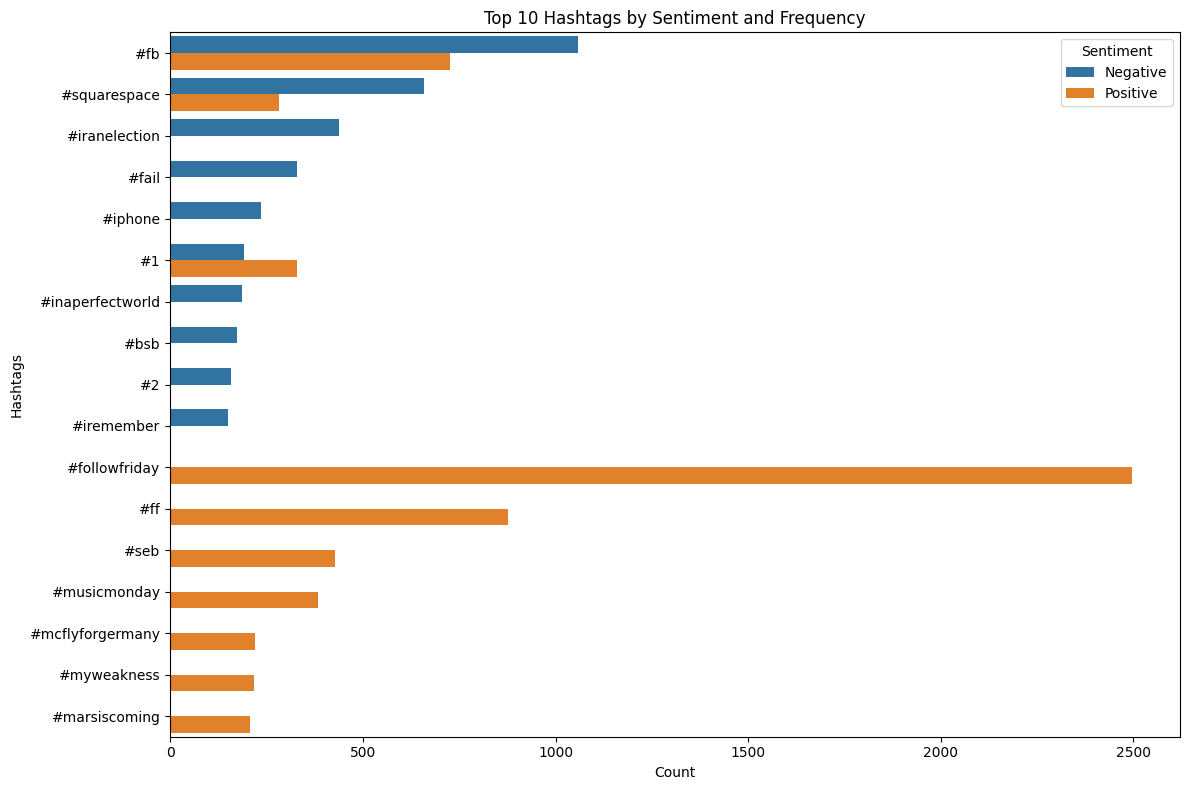

In [10]:
# Extracting hashtags 
def extract_hashtags(text):
    return re.findall(r'#\w+', text.lower())

data['hashtags'] = data['text'].apply(extract_hashtags)

# Explode hashtags for frequency count
exploded = data.explode('hashtags')

# Drop rows with no hashtags
exploded = exploded[exploded['hashtags'].notna() & (exploded['hashtags'] != '')]

# Count top hashtags by sentiment
top_hashtags = exploded.groupby(['sentiment', 'hashtags']).size().reset_index(name='count')

# Get top 10 per sentiment
top10_each = top_hashtags.groupby('sentiment').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top10_each, x='count', y='hashtags', hue='sentiment')
plt.title('Top 10 Hashtags by Sentiment and Frequency')
plt.xlabel('Count')
plt.ylabel('Hashtags')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

### Insight:
* **#followfriday** & **#ff** are dominant **positive engagement** drivers, indicating that community-building and user-recognition hashtags significantly contribute to positive sentiment. These could be leveraged in social media campaigns to boost brand goodwill and user interaction.
  
* **#fb** & **#squarespace** appear prominently in both **positive** and **negative contexts**, suggesting they are high-engagement hashtags but polarizing in sentiment. Brands associated with these terms should monitor discussions closely to manage reputation and respond to feedback effectively.

### What Time of Day Do Users Post the Most Positive or Negative Tweets?

<Figure size 1200x600 with 0 Axes>

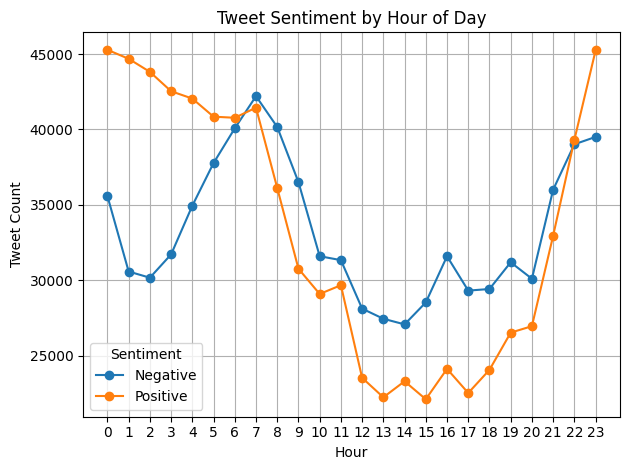

In [11]:
# Extract hour from the timestamp
data['hour'] = data['date'].dt.hour

# Group by hour and sentiment
hourly_sentiment = data.groupby(['hour', 'sentiment']).size().unstack().fillna(0)

# Plot
plt.figure(figsize=(12, 6))
hourly_sentiment.plot(kind='line', marker='o')
plt.title('Tweet Sentiment by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Tweet Count')
plt.grid(True)
plt.legend(title='Sentiment')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

### Insight:
* **Positive sentiment** peaks significantly during late evening hours **(22:00 to 23:00)**, indicating higher user positivity during the end of the day, potentially due to leisure time and reduced stress levels.

* Conversely, **negative sentiment** shows elevated activity during morning hours **(06:00 to 10:00)**, suggesting increased expressions of dissatisfaction or frustration, possibly linked to daily routines or early-day stressors.

* These findings highlight optimal time windows for sentiment-aware content scheduling. For instance, late evening hours may be ideal for disseminating positive brand messaging, while early mornings may warrant closer monitoring for potential reputational risks or customer dissatisfaction on social media platforms.